In [ ]:
!pip install transformers==4.12.5 --quiet
!pip install py_vncorenlp==0.1.3 --quiet
!pip install sentencepiece --quiet
!pip install tokenizer --quiet
!pip install underthesea --quiet
!pip install visen
!pip install pip install multiprocesspandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 50.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.3/591.3 KB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata

In [ ]:
import json
import re
import string

import numpy as np
import pandas as pd
from google.colab import drive

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import py_vncorenlp
from underthesea import word_tokenize, text_normalize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import optim

from transformers import *
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import visen
import requests
import torchvision.transforms as transforms
from multiprocesspandas import applyparallel

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
le = LabelEncoder()

In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/cfsdata/data1.csv')
df2 = pd.read_csv('/content/drive/My Drive/cfsdata/data2.csv') 
df3 = pd.read_csv('/content/drive/My Drive/cfsdata/data3.csv')
df4 = pd.read_csv('/content/drive/My Drive/cfsdata/data4.csv')

In [ ]:
uetcfs_data = pd.concat([df1,df2,df3,df4])
# uetcfs_data = df2

uetcfs_data.loc[uetcfs_data['Spam'].isna(), 'Spam'] = 0
uetcfs_data.loc[uetcfs_data['Others'].isna(), 'Others'] = 0
uetcfs_data.loc[uetcfs_data['Học tập'].isna(), 'Học tập'] = 0
uetcfs_data.loc[uetcfs_data['Đời sống'].isna(), 'Đời sống'] = 0
uetcfs_data.shape

(6291, 9)

In [ ]:
uetcfs_data.loc[uetcfs_data['Học tập'].astype(float) == 1, 'Tag'] = 0
uetcfs_data.loc[uetcfs_data['Đời sống'].astype(float) == 1, 'Tag'] = 1
uetcfs_data.loc[uetcfs_data['Others'].astype(float) == 1, 'Tag'] = 2
uetcfs_data.loc[uetcfs_data['Spam'].astype(float) == 1, 'Tag'] = 3
uetcfs_data['category'] = uetcfs_data['Tag']
uetcfs_data['category'] = le.fit_transform(uetcfs_data['category'])
uetcfs_data = uetcfs_data[['content', 'category']]

# uetcfs_data.drop(uetcfs_data[uetcfs_data['category'] == 4].index, inplace = True)

In [ ]:
uetcfs_data['category'].value_counts()

2    2098
0    1990
1    1308
3     895
Name: category, dtype: int64

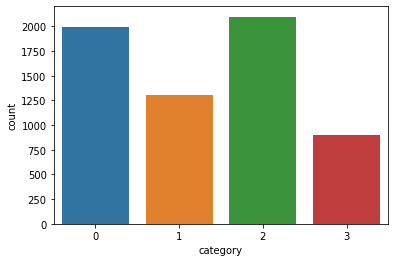

In [ ]:
sns.countplot(x='category', data=uetcfs_data)

In [ ]:
py_vncorenlp.download_model(save_dir='/content/drive/My Drive/cfsdata')
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/drive/My Drive/cfsdata')

The VnCoreNLP model is already!


In [ ]:
def word_segment(text):
  return "".join(["".join(sen) for sen in rdrsegmenter.word_segment(text_normalize(text))])

In [ ]:
def preprocess_text(text):
  text = re.sub(r'<[^>]*>', '', text)
  text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)
  text = re.sub(r'\W', ' ', text)
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
  text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
  text = re.sub(r'\w*\d\w*', ' ', text).strip()
  text = re.sub(r'\s+', ' ', text, flags=re.I)
  text = text.lower()
  text = word_segment(text)
  return text

In [ ]:
uetcfs_data['content'] = uetcfs_data['content'].apply(preprocess_text)
uetcfs_data

,content,category
0,xin chào những người anh_em thiện lành bên hàn...,1
1,to tnh cnt love more can say can be my boyfrie...,2
2,sắp tới có giải lol sinh_viên không biết uet c...,1
3,hôm_nay tình_cờ xem được một trận của đội bóng...,2
4,chào em cô gái tháng vì một_chút tình_cờ mình ...,2
...,...,...
792,uet news thời_gian bắt_đầu năm_học mới và kế_h...,0
793,tri_ân ban chủ_nhiệm sguet nhiệm_kỳ bước qua n...,2
794,uet news thông_báo về việc tuyển_sinh chương_t...,0
795,uet news kết_quả đăng_ký học chính thức và mở ...,0


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.99M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_set, test_data = train_test_split(uetcfs_data, test_size=0.1, random_state=42, shuffle=True)
train_data, val_data = train_test_split(train_set, test_size=0.28, random_state=42, shuffle=True)
train_data.shape, test_data.shape, val_data.shape

((4075, 2), (630, 2), (1586, 2))

In [ ]:
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [ ]:
# hyperparameters
MAX_LEN = 256
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 2e-5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from sklearn.preprocessing import LabelBinarizer

def encoding(data, tokenizer, max_token_len=128):
  contents = data.content
  input_ids = []
  attention_masks = []

  for index, content in enumerate(contents):
    encoded = tokenizer.encode_plus(
      content,
      truncation=True,
      add_special_tokens=True,
      max_length=max_token_len,
      padding="max_length",
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids.append(encoded["input_ids"])
    attention_masks.append(encoded["attention_mask"])

  input_ids = torch.cat(input_ids,dim=0)
  attention_masks = torch.cat(attention_masks,dim=0)
  category = torch.tensor(np.array(data.category))
  return input_ids, attention_masks, category

In [ ]:
from torch.utils.data import TensorDataset, random_split

y = LabelBinarizer().fit_transform(uetcfs_data['category'])

train_input_ids, train_attention_masks, train_encoded_label_tensors = encoding(train_data, tokenizer, max_token_len=MAX_LEN)
val_input_ids, val_attention_masks, val_encoded_label_tensors = encoding(val_data, tokenizer, max_token_len=MAX_LEN)
test_input_ids, test_attention_masks, test_encoded_label_tensors = encoding(test_data, tokenizer, max_token_len=MAX_LEN)
    
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_encoded_label_tensors)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_encoded_label_tensors)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_encoded_label_tensors)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class BertBase(nn.Module):

  def __init__(self, n_classes, drop_out=0.1):
    super(BertBase, self).__init__()
    self.bert = AutoModel.from_pretrained("vinai/phobert-base")
    self.classifier = nn.Sequential(
        nn.Dropout(drop_out),
        nn.Linear(self.bert.config.hidden_size, n_classes)
    )

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    return self.classifier(output.pooler_output)

In [ ]:
class BertLSTM(nn.Module):

  def __init__(self, n_classes, drop_out=0.1):
    super(BertLSTM, self).__init__()
    self.bert = AutoModel.from_pretrained("vinai/phobert-base")
    self.lstm = nn.LSTM(768, 128, bidirectional=True, batch_first=True)
    self.dropout = nn.Dropout(drop_out)
    self.fc = nn.Linear(256, n_classes)

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = output[0]
    enc_hiddens, (last_hidden, last_cell) = self.lstm(output)
    output = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
    output = self.dropout(output)
    output = self.fc(output) 

    return output

In [ ]:
class BertCNN(nn.Module):
  def __init__(self, embedding_dim=768, n_filters=64, filter_sizes=[1, 2, 3, 5], n_classes=4, drop_out=0.1):
    super(BertCNN, self).__init__()
    self.bert = AutoModel.from_pretrained("vinai/phobert-base")
    self.convs1 = nn.ModuleList([nn.Conv2d(1, n_filters, (K, embedding_dim)) for K in filter_sizes])
    self.dropout = nn.Dropout(drop_out)
    self.fc = nn.Linear(len(filter_sizes) * n_filters, n_classes)

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = output[0].unsqueeze(1)
    output = [F.relu(conv(output)).squeeze(3) for conv in self.convs1]
    output = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in output]  
    output = torch.cat(output, 1)
    output = self.dropout(output)
    output = self.fc(output)    
    return output

In [ ]:
model = BertLSTM(n_classes=4)
model = model.to(device)

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train_epoch(model, optimizer, scheduler, train_loader):
    model.train()
    total_loss = total = 0
    total_correct = 0
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    predictions = []
    labels = []
    for batch in progress_bar:

        label = batch[2].type(torch.LongTensor)
        label = label.to(device)
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)

        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        output = model(input_ids, attention_masks)
        
        # Calculate how wrong the model is
        
        loss = criterion(output, label)
        preds = torch.argmax(output, dim=1)

        total_correct += torch.sum(preds == label.data)
        
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(label)

    return total_correct / total, total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss = total = 0
    total_correct = 0
    predictions = []
    labels = []
    with torch.no_grad():
        progress_bar = tqdm(valid_loader, desc='Validating', leave=False)
        for batch in progress_bar:
            label = batch[2].type(torch.LongTensor)
            label = label.to(device)
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)

            # Forwards pass
            output = model(input_ids, attention_masks)

            preds = torch.argmax(output, 1)
            predictions.append(preds.flatten())
            labels.append(label.data)
            
            total_correct += torch.sum(preds == label.data)

            # Calculate how wrong the model is
            loss = criterion(output, label)

            # Record metrics
            total_loss += loss.item()
            total += len(label)

    predictions = torch.cat(predictions).detach().cpu()
    labels = torch.cat(labels).detach().cpu()
    print(classification_report(labels, predictions))
    return total_correct / total, total_loss / total


def predict_test(model, test_loader):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Validating', leave=False)
        for batch in progress_bar:
            label = batch[2].type(torch.LongTensor)
            label = label.to(device)
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)

            # Forwards pass
            output = model(input_ids, attention_masks)

            _, preds = torch.max(output, 1)
            predictions.append(preds.flatten())
            labels.append(label.data)

    predictions = torch.cat(predictions).detach().cpu()
    return predictions

In [ ]:
criterion = nn.CrossEntropyLoss()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, eps=1e-8)
    
num_training_steps = EPOCHS * len(train_dataloader)

lr_scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [ ]:
best_valid_loss = 1
train_losses, valid_losses = [], []

for epoch in range(EPOCHS):

    train_acc, train_loss = train_epoch(model, optimizer, lr_scheduler, train_dataloader)
    valid_acc, valid_loss = validate_epoch(model, val_dataloader)

    
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), '/content/drive/My Drive/cfsdata/bertLSTM_category.pt')
      # torch.save({'epoch': epoch,
      #           'model_state_dict': model.state_dict(),
      #           'optimizer_state_dict': optimizer.state_dict(),
      #           'loss': criterion,
      #           }, '/content/drive/My Drive/cfsdata/bertLSTM_category.pt')

    print('Epoch {}/{}'.format(epoch, EPOCHS - 1))
    print('-' * 10)
    print('Training Loss: {:.2e} Acc: {:.8f}'.format(train_loss, train_acc))
    print('Validate Loss: {:.2e} Acc: {:.8f}'.format(valid_loss, valid_acc))
    # print('ROC AUC Score: {: .8f}'.format(roc_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print()

Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       490
           1       0.52      0.51      0.51       337
           2       0.72      0.84      0.78       525
           3       0.98      0.81      0.89       234

    accuracy                           0.75      1586
   macro avg       0.77      0.74      0.75      1586
weighted avg       0.76      0.75      0.75      1586

Epoch 0/4
----------
Training Loss: 2.74e-02 Acc: 0.67975461
Validate Loss: 2.14e-02 Acc: 0.74842370



Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       490
           1       0.58      0.50      0.54       337
           2       0.74      0.83      0.78       525
           3       0.98      0.82      0.89       234

    accuracy                           0.77      1586
   macro avg       0.78      0.75      0.76      1586
weighted avg       0.77      0.77      0.77      1586

Epoch 1/4
----------
Training Loss: 1.91e-02 Acc: 0.78159511
Validate Loss: 1.93e-02 Acc: 0.76796973



Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       490
           1       0.61      0.47      0.53       337
           2       0.76      0.82      0.79       525
           3       0.98      0.83      0.90       234

    accuracy                           0.78      1586
   macro avg       0.79      0.76      0.77      1586
weighted avg       0.77      0.78      0.77      1586

Epoch 2/4
----------
Training Loss: 1.69e-02 Acc: 0.80687118
Validate Loss: 1.93e-02 Acc: 0.77616644



Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       490
           1       0.57      0.58      0.57       337
           2       0.79      0.75      0.77       525
           3       0.98      0.83      0.90       234

    accuracy                           0.77      1586
   macro avg       0.78      0.76      0.77      1586
weighted avg       0.77      0.77      0.77      1586

Epoch 3/4
----------
Training Loss: 1.48e-02 Acc: 0.83067489
Validate Loss: 1.96e-02 Acc: 0.76860023



Training:   0%|          | 0/128 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      0.89      0.84       490
           1       0.56      0.57      0.57       337
           2       0.79      0.76      0.77       525
           3       0.97      0.83      0.89       234

    accuracy                           0.77      1586
   macro avg       0.78      0.76      0.77      1586
weighted avg       0.77      0.77      0.77      1586

Epoch 4/4
----------
Training Loss: 1.36e-02 Acc: 0.84858900
Validate Loss: 1.94e-02 Acc: 0.76796973



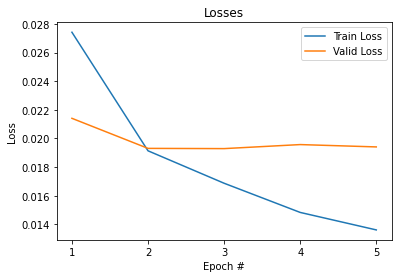

In [ ]:
epoch_ticks = range(1, EPOCHS + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [ ]:
model = BertLSTM(n_classes=4)
best_model_cp = torch.load('/content/drive/My Drive/cfsdata/bertLSTM_category.pt')
# model.load_state_dict(best_model_cp['model_state_dict'])
model.load_state_dict(best_model_cp)
model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
predictions = predict_test(model, test_dataloader)

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
guess = pd.DataFrame()
guess['content'] = test_data["content"]
guess['category'] = list(map(float, predictions))
guess

,content,category
626,chào mọi người năm nay em học lớp và có ý_định...,0.0
1738,các anh_chị cho hỏi là trường mình có_điều hoà...,1.0
116,chúc các bạn học_sinh hà_nội đi học vui_vẻ nói...,1.0
93,góc nhắc_nhở chỉ còn nửa tiếng nữa sẽ đến hạn ...,0.0
2259,cần tìm bạn nam mặc áo_khoác màu be khoa hôm u...,2.0
...,...,...
2124,chào mọi người em là năm nhất bên uet em có th...,2.0
1163,sao trong môi_trường đại_học vẫn còn những ngư...,0.0
1750,bài viết này chỉ muốn dành lời khen cho boy ue...,2.0
399,chào mọi người hiện_tại mình đang muốn học một...,0.0


In [ ]:
print(classification_report(test_data['category'], guess['category']))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85       194
           1       0.63      0.49      0.55       126
           2       0.77      0.83      0.80       218
           3       0.99      0.87      0.92        92

    accuracy                           0.79       630
   macro avg       0.80      0.77      0.78       630
weighted avg       0.78      0.79      0.78       630

